In [1]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymongo
import seaborn as sns
import humanize
import warnings
import os

In [2]:
warnings.filterwarnings('ignore')

load_dotenv()

True

In [3]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80

In [4]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

apartments.head(3)

,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,...,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
0,3708073,APARTAMENTO,VENTA,371000000.0,58.0,2.0,2.0,166000.0,1.0,GALERIAS,...,0,False,TEUSAQUILLO,SAN LUIS,Campín - UAN,707.30,0,PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD,649.66,0
1,3923506,CASA CON CONJUNTO CERRADO,VENTA,400000000.0,105.0,3.0,2.0,269100.0,1.0,TOBERIN,...,0,False,USAQUEN,VILLAS DE ARANJUEZ,Toberin - Foundever,1628.44,0,PARQUE VECINAL URBANIZACIÓN TOBERIN,831.22,0
2,3652515,APARTAMENTO,VENTA,115000000.0,45.0,2.0,1.0,58800.0,0.0,EL PORVENIR,...,0,False,BOSA,S.C. EL CORZO,Portal Américas,2654.11,0,PARQUE METROPOLITANO PORVENIR,494.80,1


In [5]:
# apartments = pd.read_csv('../data/processed/apartments.csv')
# print(apartments.shape)
# apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]
# apartments = apartments.drop(['precio_arriendo'], axis=1)
# apartments.head()

In [5]:
apartments.shape

(10500, 45)

In [6]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10500 entries, 0 to 12141
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   codigo                   10500 non-null  object 
 1   tipo_propiedad           10500 non-null  object 
 2   tipo_operacion           10500 non-null  object 
 3   precio_venta             10500 non-null  float64
 4   area                     10499 non-null  float64
 5   habitaciones             10499 non-null  float64
 6   banos                    10499 non-null  float64
 7   administracion           9517 non-null   float64
 8   parqueaderos             10499 non-null  float64
 9   sector                   9920 non-null   object 
 10  estrato                  10500 non-null  int64  
 11  antiguedad               10498 non-null  object 
 12  latitud                  10500 non-null  float64
 13  longitud                 10500 non-null  float64
 14  direccion                55

In [7]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque'],
      dtype='object')

In [8]:
apartments['datetime'] = pd.to_datetime(apartments['datetime'])

In [9]:
fotmat_tick_humanize = lambda x, pos: humanize.intword(x)

# Elimindando Outliers

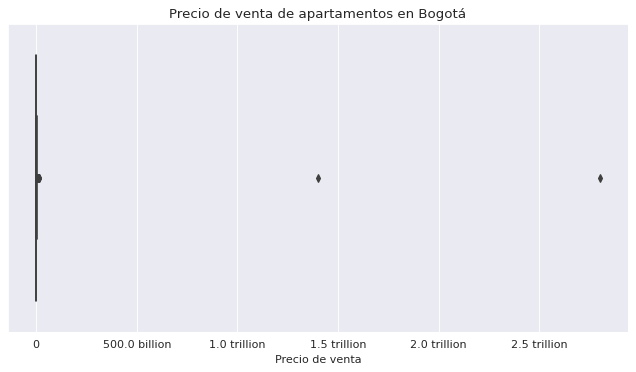

In [10]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='precio_venta', data=apartments)
plt.title('Precio de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))

In [11]:
Q1 = apartments['precio_venta'].quantile(0.25)
Q3 = apartments['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.8 * IQR
upper = Q3 + 1.8 * IQR

if lower < 0:
    lower = Q1 - 0.4 * IQR

outliers = apartments.loc[(apartments['precio_venta'] < lower) | (apartments['precio_venta'] > upper)]
outliers.shape
# lower, upper

(579, 45)

In [12]:
apartments = apartments[(apartments['precio_venta'] > lower) & (apartments['precio_venta'] < upper)]
apartments.shape

(9921, 45)

# Analisis Univariado

In [13]:
# selecionar todos los meses de datetime
apartments['month'] = apartments['datetime'].dt.month

In [14]:
apartments['month_name'] = apartments['month'].replace({1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
                                   7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})

In [15]:
apartments['month_name'].value_counts()

month_name
Enero    9921
Name: count, dtype: int64

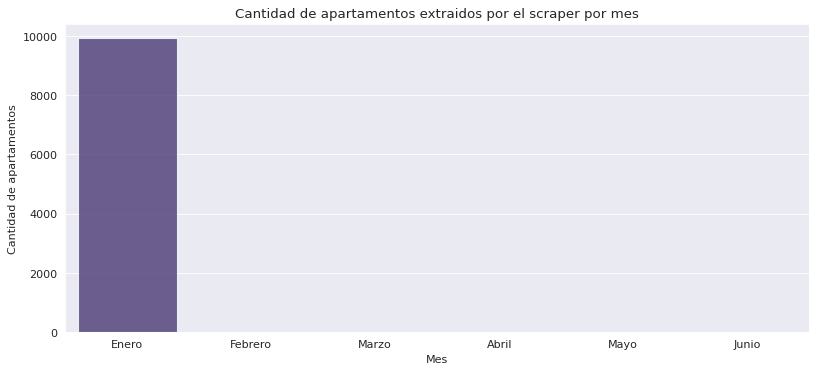

In [17]:
plt.figure(figsize=(12, 5))

sns.countplot(
    x='month_name', 
    data=apartments,
    palette='viridis',
    alpha=.8,
    # ordenar por el mes
    order=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',]
)

plt.title('Cantidad de apartamentos extraidos por el scraper por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de apartamentos')
plt.savefig('../visualizations/apartments_by_month.png', bbox_inches='tight')
plt.show()

In [18]:
apartments['localidad'].value_counts()

localidad
USAQUEN               3734
CHAPINERO             2337
SUBA                  1889
KENNEDY                415
FONTIBON               347
TEUSAQUILLO            296
ENGATIVA               294
SANTA FE               131
BOSA                   127
CIUDAD BOLIVAR          77
BARRIOS UNIDOS          64
PUENTE ARANDA           52
USME                    36
RAFAEL URIBE URIBE      29
ANTONIO NARINO          27
LOS MARTIRES            25
SAN CRISTOBAL           17
CANDELARIA              16
TUNJUELITO               8
Name: count, dtype: int64

## Precio de Venta

In [20]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,"9,921.0","842,967,246.3590364","624,970,980.2580469","90,000,000.0","380,000,000.0","630,000,000.0","1,180,000,000.0","2,900,000,000.0"


In [21]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intword(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,9.9 thousand,843.0 million,625.0 million,90.0 million,380.0 million,630.0 million,1.2 billion,2.9 billion


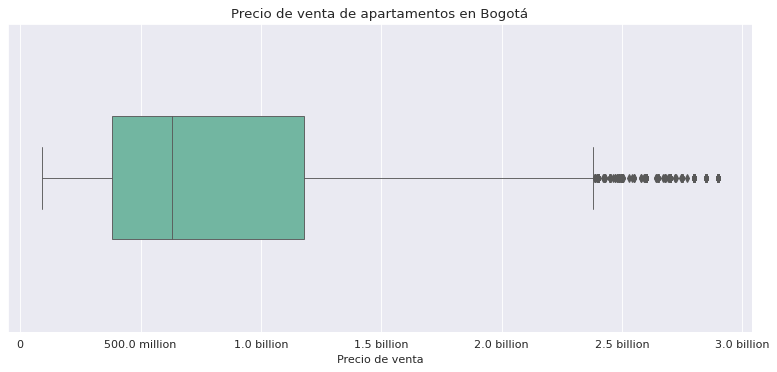

In [22]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.show()

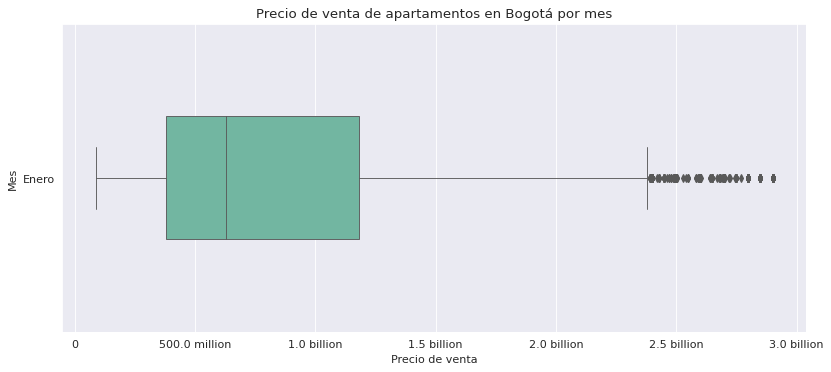

In [23]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    y='month_name',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá por mes')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.ylabel('Mes')
plt.show()

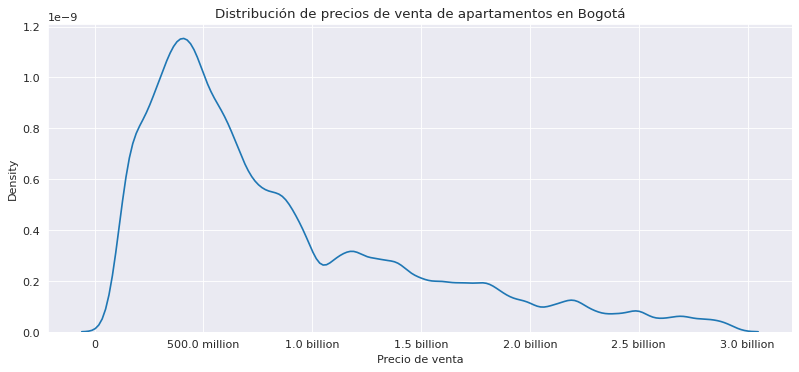

In [24]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [25]:
stat, p = stats.normaltest(apartments['precio_venta'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1695.952, p=0.000


In [26]:
alpha = 0.05
if p > alpha:
    print('La muestra parece Gaussiana (no rechazar H0)')
else:
    print('La muestra no parece Gaussiana (rechazar H0)')

La muestra no parece Gaussiana (rechazar H0)


In [27]:
apartments['is_cerca_estacion_tm'].value_counts()

is_cerca_estacion_tm
0    7957
1    1964
Name: count, dtype: int64

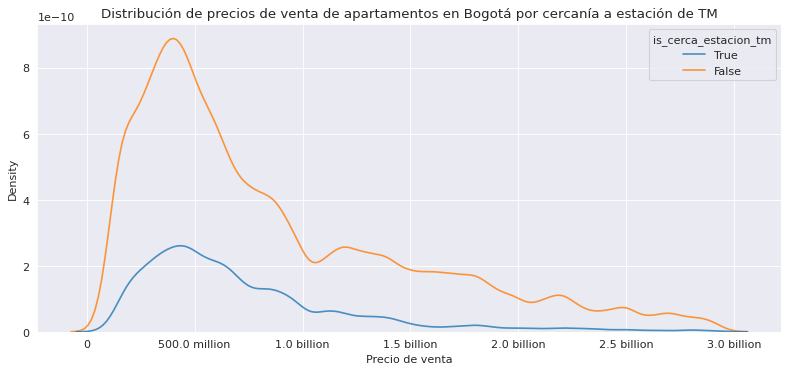

In [28]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    bw_adjust=.5,
    hue_order=[True, False],
    alpha=.8,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

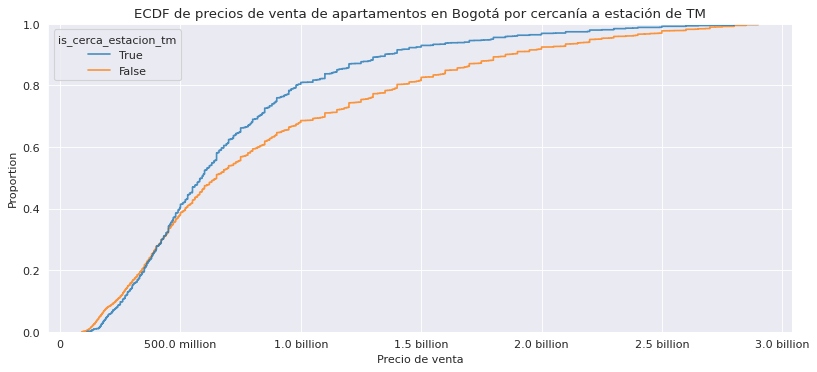

In [29]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    alpha=.8,
)

plt.title('ECDF de precios de venta de apartamentos en Bogotá por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [30]:
# stats de precio por cada mes
stats_month = apartments.groupby('month_name')['precio_venta'].describe()
stats_month

,count,mean,std,min,25%,50%,75%,max
month_name,,,,,,,,
Enero,9921.0,8.429672e+08,6.249710e+08,90000000.0,380000000.0,630000000.0,1.180000e+09,2.900000e+09


In [31]:
# stats de precio por localidad

stats_localidad = apartments.groupby('localidad')['precio_venta'].describe()
stats_localidad.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
localidad,,,,,,,,
CHAPINERO,2337.0,1.338254e+09,6.972058e+08,180000000.0,730000000.0,1.270000e+09,1.850000e+09,2.900000e+09
USAQUEN,3734.0,8.856289e+08,5.485395e+08,150000000.0,465425000.0,7.300000e+08,1.197750e+09,2.900000e+09
SUBA,1889.0,6.298184e+08,4.391506e+08,125000000.0,350000000.0,5.000000e+08,7.500000e+08,2.900000e+09
TEUSAQUILLO,296.0,5.852377e+08,3.006322e+08,167000000.0,399500000.0,5.469500e+08,6.800000e+08,2.700000e+09
SANTA FE,131.0,5.290992e+08,3.263595e+08,114000000.0,330000000.0,4.380000e+08,6.500000e+08,2.250000e+09
FONTIBON,347.0,5.285405e+08,3.999382e+08,124800000.0,270865000.0,4.300000e+08,6.400000e+08,2.600000e+09
BARRIOS UNIDOS,64.0,4.570470e+08,1.275499e+08,255000000.0,370750000.0,4.240000e+08,5.200000e+08,7.950000e+08
CANDELARIA,16.0,4.312500e+08,1.834076e+08,230000000.0,270000000.0,4.050000e+08,4.750000e+08,8.400000e+08
ANTONIO NARINO,27.0,3.589462e+08,8.988166e+07,178000000.0,285000000.0,4.069920e+08,4.218775e+08,4.900000e+08


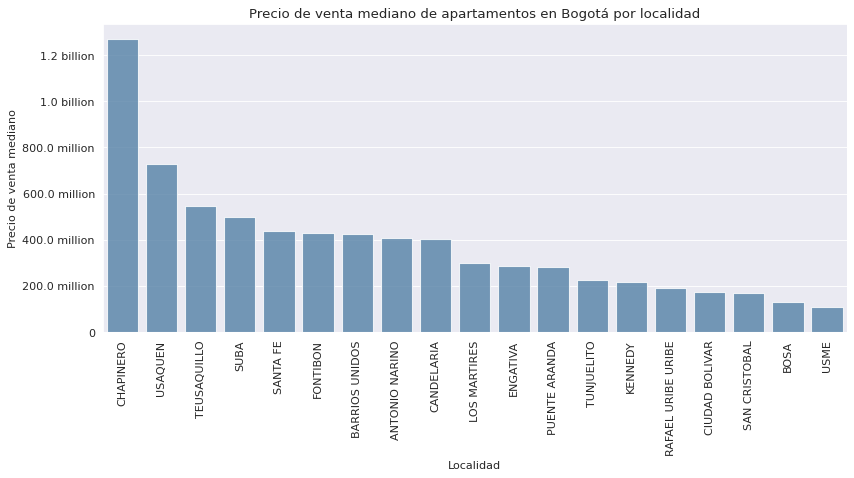

In [32]:
plt.figure(figsize=(12, 5))

sns.barplot(
    x=stats_localidad.index,
    y=stats_localidad['50%'],
    alpha=.8,
    order=stats_localidad.sort_values(by='50%', ascending=False).index,
    color='steelblue',
)

plt.title('Precio de venta mediano de apartamentos en Bogotá por localidad')
plt.xlabel('Localidad')
plt.ylabel('Precio de venta mediano')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xticks(rotation=90)
plt.show()

In [33]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque', 'month', 'month_name'],
      dtype='object')

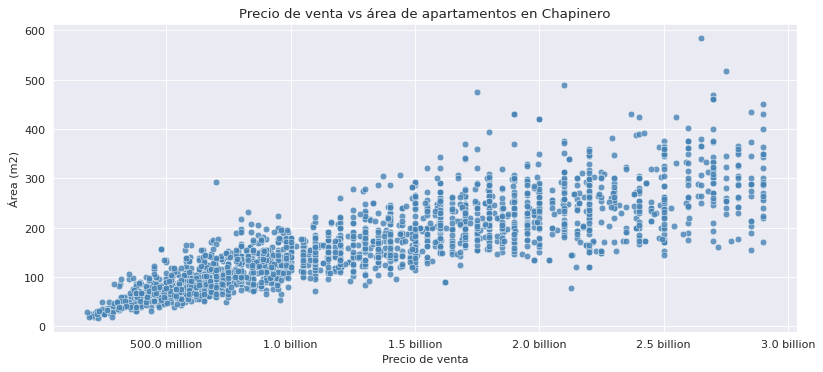

In [34]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    data=apartments.loc[apartments['localidad'] == 'CHAPINERO'],
    x='precio_venta',
    y=apartments['area'].loc[(apartments['localidad'] == 'CHAPINERO') & (apartments['area'] < 800) & (apartments['area'] > 0)],
    alpha=.8,
    color='steelblue',
)

plt.title('Precio de venta vs área de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.ylabel('Área (m2)')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [35]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque', 'month', 'month_name'],
      dtype='object')

In [38]:
apartments['is_cerca_parque'].value_counts()

is_cerca_parque
0    7388
1    2533
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribución de precios de venta de apartamentos en Bogotá por cercanía a parque')

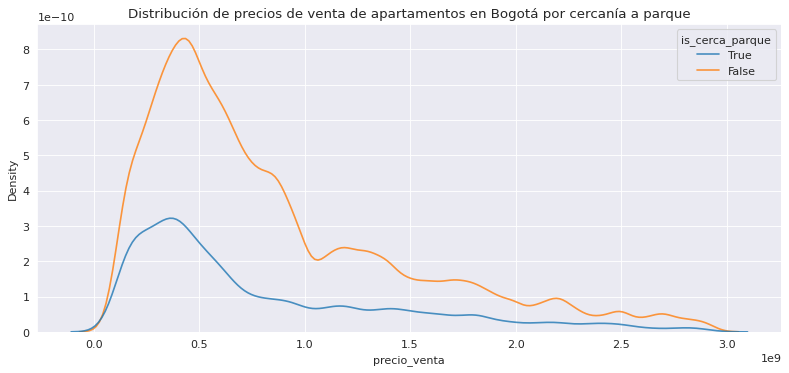

In [39]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    hue='is_cerca_parque',
    bw_adjust=.5,
    hue_order=[True, False],
    alpha=.8,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá por cercanía a parque')


In [36]:
apartments['last_view'] = pd.to_datetime(apartments['last_view'])

apartments['last_view'].dt.month.value_counts()

last_view
1    9921
Name: count, dtype: int64

In [37]:
apartments.website.value_counts()

website
metrocuadrado.com    9364
habi.co               557
Name: count, dtype: int64